# Generate trace sampling input from RadicalPy simulator

In [1]:
import radicalpy as rp
from radicalpy.simulation import State
import numpy as np
import matplotlib.pyplot as plt

import sys
import pathlib

sys.path.append(str(pathlib.Path().resolve()))

from utils import dump_input, parse_output  # ty: ignore

In [2]:
is_small_case = True

if is_small_case:
    # You can use following block instead
    n_nuc_spins = 1

    flavin = rp.simulation.Molecule.fromisotopes(
        isotopes=["1H", "14N"], hfcs=[0.4, 0.5]
    )
    Z = rp.simulation.Molecule.fromisotopes(
        isotopes=["1H"] * n_nuc_spins,
        hfcs=[0.5] * n_nuc_spins,
        # isotopes=[], hfcs=[]
    )
    sim = rp.simulation.LiouvilleSimulation([Z, flavin])

    # Parameters
    A = {}  # mT
    isotropic = True

    # Isotropic
    for i in range(len(sim.radicals)):
        for j, nuc in enumerate(sim.molecules[i].nuclei):
            if isotropic:
                A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
            else:
                A[(i, j)] = nuc.hfc.anisotropic
    B0 = 0.2  # 2J
    B = np.array((0.0, 0.0, 1.0)) * B0  # mT
    J = 0.1  # Typically 1.0e+03 scale # mT
    D = 0.1  # mT
    kS = 1.0e06  # Exponential model in s-1
    kT = 1.0e06
    if isinstance(D, float):
        D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D * sim.radicals[0].gamma_mT
else:
    flavin = rp.simulation.Molecule.all_nuclei("flavin_anion")
    trp = rp.simulation.Molecule.all_nuclei("tryptophan_cation")
    sim = rp.simulation.LiouvilleSimulation([flavin, trp])
    A = {}
    isotropic = False
    for i in range(len(sim.radicals)):
        for j, nuc in enumerate(sim.molecules[i].nuclei):
            if isotropic:
                A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
            else:
                A[(i, j)] = nuc.hfc.anisotropic
    B0 = 2.0  # Typically 0.01 mT~10 mT
    B = np.array((0.0, 0.0, 1.0)) * B0
    J = 0.1  # Typically 1.0e+03 scale

    D = (
        np.array(
            [
                [-0.225, 0.156, 0.198],
                [0.156, 0.117, -0.082],
                [0.198, -0.082, 0.107],
            ]
        )
        * sim.radicals[0].gamma_mT
    )
    kS = 1.0e06  # Exponential model in s-1
    kT = 1.0e06
    if isinstance(D, float):
        D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D * sim.radicals[0].gamma_mT
sim

Number of electrons: 2
Number of nuclei: 3
Number of particles: 5
Multiplicities: [2, 2, 2, 2, 3]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023, 267522.18744, 267522.18744, 19337.792]
Nuclei: [1H(267522187.44, 2, 0.5 <anisotropic not available>), 1H(267522187.44, 2, 0.4 <anisotropic not available>), 14N(19337792.0, 3, 0.5 <anisotropic not available>)]
Couplings: [0, 1, 1]
HFCs (mT): [0.5 <anisotropic not available>, 0.4 <anisotropic not available>, 0.5 <anisotropic not available>]

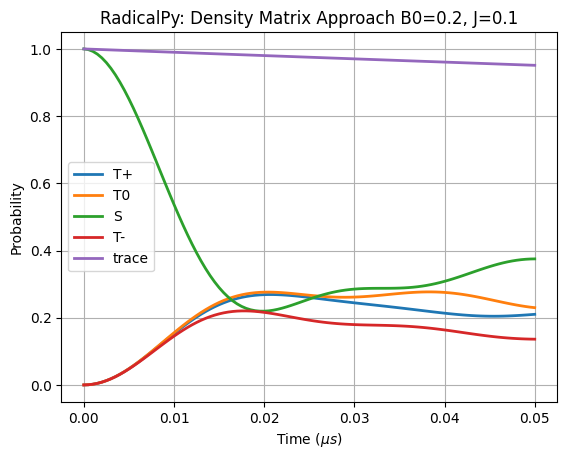

In [3]:
if is_small_case:
    # when D is Float, a bug appears
    assert isinstance(D, np.ndarray)
    H = sim.total_hamiltonian(B0=B0, D=D, J=J)
    time = np.arange(0, 5.0e-8 + 5e-10, 5e-10)
    kinetics = [
        rp.kinetics.Haberkorn(kS, rp.simulation.State.SINGLET),
        rp.kinetics.Haberkorn(kT, rp.simulation.State.TRIPLET),
    ]
    sim.apply_liouville_hamiltonian_modifiers(H, kinetics)
    rhos = sim.time_evolution(State.SINGLET, time, H)

    time_evol_s = sim.product_probability(State.SINGLET, rhos)
    time_evol_tp = sim.product_probability(State.TRIPLET_PLUS, rhos)
    time_evol_tz = sim.product_probability(State.TRIPLET_ZERO, rhos)
    time_evol_tm = sim.product_probability(State.TRIPLET_MINUS, rhos)
    x = time * 1e6

    plt.plot(x, time_evol_tp, linewidth=2, label="T+")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0")
    plt.plot(x, time_evol_s, linewidth=2, label="S")
    plt.plot(x, time_evol_tm, linewidth=2, label="T-")
    plt.plot(
        x,
        time_evol_tp + time_evol_tz + time_evol_s + time_evol_tm,
        linewidth=2,
        label="trace",
    )
    plt.legend()
    plt.title(f"RadicalPy: Density Matrix Approach {B0=}, {J=}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel("Probability")
    # plt.ylim([0, 1])
    plt.grid()
    plt.show()

In [4]:
input_path, output_path = dump_input(
    sim=sim,
    output_folder="out",
    simulation_type="trace_sampling",  # "exact_dynamics", "trace_sampling"
    J=J,
    D=D,
    kS=kS,
    kT=kT,
    B=B0,
    dt=5e-10,
    simulation_time=5e-08 - 5e-10,
    N_krylov=10,
    integrator_tolerance=1e-08,
    N_samples=1024,
)
print(input_path)
# cat contents of input file
with open(input_path) as f:
    print(f.read())

remove output folder
create output folder /home/hinom/GitHub/Spin_dynamics/example/out
/home/hinom/GitHub/Spin_dynamics/example/input.ini
[system variables]
J = 0.1
D = -0.06666666666666667 0.0 0.0 0.0 -0.06666666666666667 0.0 0.0 0.0 0.13333333333333333
kS = 1.0
kT = 1.0
[electron 1]
g = 2.0023193
I = 2
N_I = 1
A1 = 0.5 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.5
[electron 2]
g = 2.0023193
I = 2 3
N_I = 1 1
A1 = 0.4 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.4
A2 = 0.5 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.5
[simulation parameters]
simulation_type = exact_dynamics
output_folder = out
seed = 42 99
B = 0.2
initial_state = singlet
simulation_time = 49.5
dt = 0.5
N_krylov = 10
integrator_tolerance = 1e-08



In [5]:
# Execute sphinchem
import subprocess

subprocess.run(["../bin/spinchem", input_path])

 Program initialised
           1
           2
  -6.6666666666666666E-002  -6.6666666666666666E-002  0.13333333333333333       0.10000000000000001        0.0000000000000000     
Time elapsed:   0: 0: 0


CompletedProcess(args=['../bin/spinchem', PosixPath('/home/hinom/GitHub/Spin_dynamics/example/input.ini')], returncode=0)

In [6]:
df = parse_output(output_path="out", subdir=".200", dt=5e-10)

In [7]:
df

S_prob,Tm_prob,Tp_prob,T0_prob,time
f64,f64,f64,f64,f64
1.0,0.0,0.0,0.0,0.0
0.997939,0.00052,0.00052,0.00052,0.0005
0.992773,0.002076,0.002075,0.002076,0.001
0.984552,0.004651,0.004646,0.004653,0.0015
0.973353,0.008219,0.008204,0.008226,0.002
…,…,…,…,…
0.37093,0.206429,0.137994,0.237781,0.048
0.372655,0.207221,0.137319,0.235463,0.0485
0.373916,0.208107,0.136793,0.233366,0.049


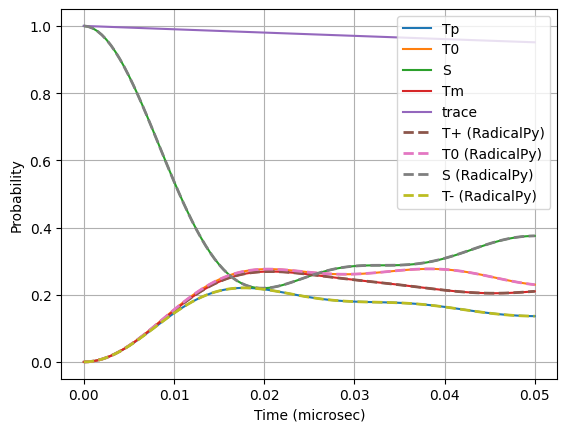

In [8]:
plt.plot(df["time"], df["Tp_prob"], label="Tp")
plt.plot(df["time"], df["T0_prob"], label="T0")
plt.plot(df["time"], df["S_prob"], label="S")
plt.plot(df["time"], df["Tm_prob"], label="Tm")
plt.plot(
    df["time"],
    df["S_prob"] + df["T0_prob"] + df["Tp_prob"] + df["Tm_prob"],
    label="trace",
)
plt.plot(x, time_evol_tp, linewidth=2, label="T+ (RadicalPy)", ls="--")
plt.plot(x, time_evol_tz, linewidth=2, label="T0 (RadicalPy)", ls="--")
plt.plot(x, time_evol_s, linewidth=2, label="S (RadicalPy)", ls="--")
plt.plot(x, time_evol_tm, linewidth=2, label="T- (RadicalPy)", ls="--")
plt.xlabel("Time (microsec)")
plt.ylabel("Probability")
plt.grid()
plt.legend()
plt.show()